# Exam Project
## A Study of the Factors Influencing Movie and Television Series Rankings

*****Group 32 : Shreya Pattabhiram Iyer, Kavinan Kirubendran*****

In [2]:
# importing all libraries used in this project

import numpy as np
import pandas as pd


# for web scraping

import requests
import re
from bs4 import BeautifulSoup
import time


# for analysis

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# for modelling with svm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


# for creating model report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

## Part 1: Web Scraping for Data Collection

### Part 1.1: Movies Data Scraping

In [3]:
# Data Scraping for MOVIES

# code for gathering data from the IMDb website

years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

movie_title = []
movie_runtime = []
movie_imdb = []
movie_genre = []
movie_cert = []
movie_votes = []
movie_profit = []
movie_director = []
movie_stars = []
movie_year = []

year_total = []

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36 - Collecting data for research project',
    'From': 'ksl450@alumni.ku.dk'
}

for year in years:
    page_start = 1
    url_y = 'https://www.imdb.com/search/title/?title_type=feature&year='+str(year)+'-01-01,'+str(year)+'-12-31&start='+str(page_start)+'&ref_=adv_nxt'
    res_y = requests.get(url_y, headers = headers)
    soup_y = BeautifulSoup(res_y.content, 'html.parser')
    
    #time.sleep(1)

    total_movie = 0
    page_desc = soup_y.find_all('div', {'class': 'desc'})
    for i in page_desc:
        children = i.findChildren("span" , recursive=False)
        total_movie = int(children[0].text[8:-8].replace(',',''))
    year_total.append(total_movie)
    #pages = math.floor(total_movie/50)
    
    while page_start < total_movie+1 and page_start < 10000:
        
        url = 'https://www.imdb.com/search/title/?title_type=feature&year='+str(year)+'-01-01,'+str(year)+'-12-31&start='+str(page_start)+'&ref_=adv_nxt'
        res = requests.get(url, headers = headers)
        soup = BeautifulSoup(res.content, 'html.parser')
        
        #time.sleep(2)

        movie_par = soup.find_all('div', {'class': 'lister-item-content'})
        
        for m in movie_par:
            
            #Title
            movie_title.append(m.h3.a.text)

            #Get IMDb of movies
            imdb_par = m.div
            if imdb_par is None:
                movie_imdb.append(np.nan)
            else:
                imdb_children = imdb_par.findChildren("div" , recursive=False)
                if len(imdb_children)>1:
                    movie_imdb.append(float(imdb_children[0].text))
                else:
                    movie_imdb.append(np.nan)


            #To retreive p elements
            p_children = m.findChildren("p" , recursive=False)


            #Genre, runtime and certificate parent
            genre_runtime_cert_par = p_children[0]

            #Genre
            genre_child = genre_runtime_cert_par.find('span', {'class': 'genre'})
            if genre_child is None:
                movie_genre.append(np.NaN)
            else:
                movie_genre.append(genre_child.text.strip())

            #Runtime
            runtime_child = genre_runtime_cert_par.find('span', {'class': 'runtime'})
            if runtime_child is None:
                movie_runtime.append(np.nan)
            else:
                movie_runtime.append(int(re.sub("[^0-9]", "", runtime_child.text)))

            #Certificate
            cert_child = genre_runtime_cert_par.find('span', {'class': 'certificate'})
            if cert_child is None:
                movie_cert.append(np.nan)
            else:
                movie_cert.append(cert_child.text)


            #Director and Stars parent
            director_star_par = p_children[2].contents

            #Director
            if str(director_star_par[0]).strip() == 'Director:':
                movie_director.append(director_star_par[1].text)
            elif str(director_star_par[0]).strip() == 'Directors:':
                director_child = []
                director_child.append(director_star_par[1].text)
                director_child.append(director_star_par[3].text)
                movie_director.append(", ".join(director_child))
            else:
                movie_director.append(np.NaN)

            #Stars
            temp_star_list = []
            star_count = 0
            for sub_star in range(0,len(director_star_par)):
                temp_ind_star = 0
                if str(director_star_par[sub_star]).strip() == 'Stars:':
                    star_count +=1
                    temp_ind_star = sub_star
                    for ind_star in range(temp_ind_star+1, len(director_star_par), 2):
                        temp_star_list.append(director_star_par[ind_star].text)
            if star_count == 0:
                movie_stars.append(np.NaN)
            else:
                movie_stars.append(", ".join(temp_star_list))


            #Votes and gross profit
            if len(p_children) > 3:
                votes_profit_child = [p_children[3]]
                for nv in votes_profit_child:
                    children = nv.findChildren("span" , recursive=False)

                    votes_count = 0
                    profit_count = 0
                    for count in range(0,len(children)):
                        if children[count].text == 'Votes:':
                            movie_votes.append(int(children[count+1].text.replace(',','')))
                            votes_count += 1
                        if children[count].text == 'Gross:':
                            movie_profit.append(float(children[count+1].text[1:-1]))
                            profit_count += 1

                    if votes_count == 0:
                        movie_votes.append(np.NaN)
                    if profit_count == 0:
                        movie_profit.append(np.NaN)
            else:
                movie_votes.append(np.NaN)
                movie_profit.append(np.NaN)
        
        
            #Year
            movie_year.append(year)
        
        
        #To direct it to next page
        page_start += 50
        
    print("Completed "+str(year))

Completed 2014
Completed 2015
Completed 2016
Completed 2017
Completed 2018
Completed 2019
Completed 2020
Completed 2021


### Part 1.2: Television Series Data Scraping

In [4]:
# Data Scraping for TELEVISION SERIES

# code for gathering data from the IMDb website

tv_title = []
tv_runtime = []
tv_imdb = []
tv_genre = []
tv_cert = []
tv_votes = []
tv_stars = []
tv_year = []

year_total_tv = []

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36 - Collecting data for research project',
    'From': 'ksl450@alumni.ku.dk'
}

for year in years:
    page_start = 1
    url_y = 'https://www.imdb.com/search/title/?title_type=tv_series&release_date='+str(year)+'-01-01,'+str(year)+'-12-31&start='+str(page_start)+'&ref_=adv_nxt'
    res_y = requests.get(url_y, headers = headers)
    soup_y = BeautifulSoup(res_y.content, 'html.parser')
    
    #time.sleep(1)

    #total_tv = 0
    page_desc = soup_y.find_all('div', {'class': 'desc'})
    for i in page_desc:
        children = i.findChildren("span" , recursive=False)
        total_tv = int(children[0].text[8:-8].replace(',',''))
    year_total_tv.append(total_tv)
    #pages = math.floor(total_tv/50)
    
    while page_start < total_tv+1 and page_start < 10000:
        
        url = 'https://www.imdb.com/search/title/?title_type=tv_series&release_date='+str(year)+'-01-01,'+str(year)+'-12-31&start='+str(page_start)+'&ref_=adv_nxt'
        res = requests.get(url, headers = headers)
        soup = BeautifulSoup(res.content, 'html.parser')
        
        #time.sleep(1)

        tv_par = soup.find_all('div', {'class': 'lister-item-content'})
        
        for m in tv_par:
            
            #Title
            tv_title.append(m.h3.a.text)

            #Get IMDb of series
            imdb_par = m.div
            if imdb_par is None:
                tv_imdb.append(np.nan)
            else:
                imdb_children = imdb_par.findChildren("div" , recursive=False)
                if len(imdb_children)>1:
                    tv_imdb.append(float(imdb_children[0].text))
                else:
                    tv_imdb.append(np.nan)


            #To retreive p elements
            p_children = m.findChildren("p" , recursive=False)


            #Genre, runtime and certificate parent
            genre_runtime_cert_par = p_children[0]

            #Genre
            genre_child = genre_runtime_cert_par.find('span', {'class': 'genre'})
            if genre_child is None:
                tv_genre.append(np.NaN)
            else:
                tv_genre.append(genre_child.text.strip())

            #Runtime
            runtime_child = genre_runtime_cert_par.find('span', {'class': 'runtime'})
            if runtime_child is None:
                tv_runtime.append(np.nan)
            else:
                tv_runtime.append(int(re.sub("[^0-9]", "", runtime_child.text)))

            #Certificate
            cert_child = genre_runtime_cert_par.find('span', {'class': 'certificate'})
            if cert_child is None:
                tv_cert.append(np.nan)
            else:
                tv_cert.append(cert_child.text)


            #Stars parent
            star_par = p_children[2].contents

            #Stars
            temp_star_list = []
            star_count = 0
            for sub_star in range(0,len(star_par)):
                temp_ind_star = 0
                if str(star_par[sub_star]).strip() == 'Stars:':
                    star_count +=1
                    temp_ind_star = sub_star
                    for ind_star in range(temp_ind_star+1, len(star_par), 2):
                        temp_star_list.append(star_par[ind_star].text)
            if star_count == 0:
                tv_stars.append(np.NaN)
            else:
                tv_stars.append(", ".join(temp_star_list))


            #Votes
            if len(p_children) > 3:
                votes_child = [p_children[3]]
                for nv in votes_child:
                    children = nv.findChildren("span" , recursive=False)

                    votes_count = 0
                    for count in range(0,len(children)):
                        if children[count].text == 'Votes:':
                            tv_votes.append(int(children[count+1].text.replace(',','')))
                            votes_count += 1

                    if votes_count == 0:
                        tv_votes.append(np.NaN)
            else:
                tv_votes.append(np.NaN)
        
        
            #Year
            tv_year.append(year)
        
        
        #To direct it to next page
        page_start += 50
        
    print("Completed "+str(year))

Completed 2014
Completed 2015
Completed 2016
Completed 2017
Completed 2018
Completed 2019
Completed 2020
Completed 2021


### Part 1.3: Viewing the Scraped Data

In [5]:
# view the Movies dataset

df_raw_movies_un = pd.DataFrame({'Movie':movie_title, 
                              'Year':movie_year,
                              'IMDb':movie_imdb, 
                              'Genre':movie_genre, 
                              'Duration':movie_runtime,
                              'Certificate':movie_cert,
                              'Votes':movie_votes, 
                              'Profit':movie_profit,
                              'Director':movie_director, 
                              'Stars':movie_stars})

df_raw_movies_un.head()

,Movie,Year,IMDb,Genre,Duration,Certificate,Votes,Profit,Director,Stars
0,Guardians of the Galaxy,2014,8.0,"Action, Adventure, Comedy",121.0,UA,1086971.0,333.18,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S..."
1,Interstellar,2014,8.6,"Adventure, Drama, Sci-Fi",169.0,UA,1601697.0,188.02,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch..."
2,John Wick,2014,7.4,"Action, Crime, Thriller",101.0,A,571878.0,43.04,"Chad Stahelski, David Leitch","Keanu Reeves, Michael Nyqvist, Alfie Allen, Wi..."
3,Gone Girl,2014,8.1,"Drama, Mystery, Thriller",149.0,A,901459.0,167.77,David Fincher,"Ben Affleck, Rosamund Pike, Neil Patrick Harri..."
4,Kingsman: The Secret Service,2014,7.7,"Action, Adventure, Comedy",129.0,A,612981.0,128.26,Matthew Vaughn,"Colin Firth, Taron Egerton, Samuel L. Jackson,..."


In [6]:
# view the Tevelsion Series dataset

df_raw_tvs_un = pd.DataFrame({'TV Series':tv_title, 
                              'Year':tv_year,
                              'IMDb':tv_imdb, 
                              'Genre':tv_genre, 
                              'Duration':tv_runtime,
                              'Certificate':tv_cert,
                              'Votes':tv_votes, 
                              'Stars':tv_stars})

df_raw_tvs_un.tail()

,TV Series,Year,IMDb,Genre,Duration,Certificate,Votes,Stars
75168,MasterChef Celebrity México,2021,NaN,Reality-TV,NaN,NaN,NaN,"Daniela Alexis, Jorge Aravena, Toni Balardi, J..."
75169,Super-Jahti,2021,NaN,Game-Show,NaN,NaN,NaN,"Mikko Leppilampi, Markus Leikola, Magnus Mali,..."
75170,Sabor à Prova,2021,NaN,Reality-TV,NaN,NaN,NaN,"Iasmin Albuquerque, Caco Barros, Isadora Costa..."
75171,Reset,2021,NaN,Action,10.0,NaN,NaN,"Phillip Spears, John Snyder, Robert Garret"
75172,Mohabbat Dagh Ki Soorat,2021,NaN,Drama,NaN,NaN,NaN,"Syed Jibran, Sami Khan, Sunita Marshall, Neela..."


### Part 1.4: Summary Statistics

In [7]:
df_raw_movies_un.describe()

,Year,IMDb,Duration,Votes,Profit
count,79887.000000,49367.000000,61176.000000,4.936700e+04,2696.000000
mean,2017.496176,5.882760,96.657415,4.029456e+03,24.639388
std,2.290613,1.463537,67.243392,3.123686e+04,68.940326
min,2014.000000,1.000000,1.000000,5.000000e+00,0.000000
25%,2015.000000,5.000000,82.000000,2.400000e+01,0.050000
50%,2017.000000,6.000000,93.000000,9.600000e+01,0.590000
75%,2019.000000,6.900000,107.000000,5.070000e+02,14.845000
max,2021.000000,10.000000,10062.000000,1.601697e+06,936.660000


In [8]:
df_raw_tvs_un.describe()

,Year,IMDb,Duration,Votes
count,75173.000000,25291.000000,24462.000000,25291.000000
mean,2017.351922,6.922036,41.662374,1393.389862
std,2.193910,1.476440,60.780424,13047.031477
min,2014.000000,1.000000,1.000000,5.000000
25%,2015.000000,6.200000,21.000000,12.000000
50%,2017.000000,7.200000,30.000000,33.000000
75%,2019.000000,8.000000,50.000000,155.000000
max,2021.000000,10.000000,3825.000000,897365.000000


### Part 1.5: Collecting Additional Data

In [9]:
#total movies count by year

df_raw_movies_un_ytotal = pd.DataFrame({'Year':years, 'total_movies':year_total})
df_raw_movies_un_ytotal.head()

,Year,total_movies
0,2014,10159
1,2015,10804
2,2016,11801
3,2017,12177
4,2018,12459


In [10]:
#total television series count by year

df_raw_tvs_un_ytotal = pd.DataFrame({'Year':years, 'total_tvs':year_total_tv})
df_raw_tvs_un_ytotal.head()

,Year,total_tvs
0,2014,9251
1,2015,10057
2,2016,10154
3,2017,10295
4,2018,10203


### Part 1.6: Saving the Datasets

In [11]:
# saving the 4 dataframes locally for future use

df_raw_movies_un.to_excel("IMDb_Movies.xlsx")
df_raw_tvs_un.to_excel("IMDb_TV_Series.xlsx")
df_raw_movies_un_ytotal.to_excel("Movies_ByYear.xlsx")
df_raw_tvs_un_ytotal.to_excel("TV_Series_ByYear.xlsx")

## Part 2: Data Cleaning and Merging

### Part 2.1: Cleaning Movies Dataset

In [12]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

%matplotlib inline 

# loading the movies data into a dataframe and creating a copy for use

raw_data = pd.read_excel("IMDb_Movies.xlsx")
df_raw_movies = pd.DataFrame(raw_data)
df_all_m = df_raw_movies.copy()


# selecting the columns that are useful for the analysis
# classifying movie certificate as 'Not Rated' if the value is null

df_new_m = df_all_m.iloc[:, 2:-2]
for i in range(0, len(df_new_m)):
    if pd.isna(df_new_m.iloc[i, -3]):
        df_new_m.iloc[i, -3] = 'Not Rated'

        
# deleting null values and removing 'Profit'. 'Profit' will be used later for a separate analysis
# introducing an age variable for analysis

df_genre_m = df_new_m.iloc[:,:-1].dropna()
df_genre_m['Ind'] = df_genre_m.index
df_genre_m['Age'] = 0

c_list = ['7+', '12', '12+', '13', '13+', '15', '15+', 'All', 'UA', 'G', 'R', 'PG-13', 'U', 'U/A']
a_list = ['16', '16+', '18', '18+', '7', 'A', 'NC-17', 'PG']
o_list = ['(Banned)', 'Not Rated', 'Unrated']


# classifying movies into 3 categories based on target audience: 'All', 'Adults', 'Not Known'

for i in range(0, len(df_genre_m)):
    temp = df_genre_m.iloc[i, -4]
    for x in c_list:
        if temp == x:
            df_genre_m.iloc[i, -1] = 'All'
    temp = df_genre_m.iloc[i, -4]
    for x in a_list:
        if temp == x:
            df_genre_m.iloc[i, -1] = 'Adults'
    temp = df_genre_m.iloc[i, -4]
    for x in o_list:
        if temp == x:
            df_genre_m.iloc[i, -1] = 'Not Known'

df_genre_m.head()

,Year,IMDb,Genre,Duration,Certificate,Votes,Ind,Age
0,2014,8.0,"Action, Adventure, Comedy",121.0,UA,1085689.0,0,All
1,2014,8.6,"Adventure, Drama, Sci-Fi",169.0,UA,1599662.0,1,All
2,2014,7.4,"Action, Crime, Thriller",101.0,A,571202.0,2,Adults
3,2014,8.1,"Drama, Mystery, Thriller",149.0,A,900643.0,3,Adults
4,2014,7.7,"Action, Adventure, Comedy",129.0,A,612471.0,4,Adults


In [13]:
# creating a table for dummy Age Groups and Genres

cert_tab_m = df_genre_m['Age'].str.get_dummies()
genre_tab_m = df_genre_m['Genre'].str.get_dummies(sep=', ')


# merging the 2 dummy tables with the main dataframe

pd.set_option("display.max_columns", None)
df_t_m = df_genre_m.merge(genre_tab_m, left_index=True, right_index=True)
df_t_m = df_t_m.merge(cert_tab_m, left_index=True, right_index=True)
df_t_m.head()

,Year,IMDb,Genre,Duration,Certificate,Votes,Ind,Age,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,Adults,All,Not Known
0,2014,8.0,"Action, Adventure, Comedy",121.0,UA,1085689.0,0,All,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2014,8.6,"Adventure, Drama, Sci-Fi",169.0,UA,1599662.0,1,All,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2014,7.4,"Action, Crime, Thriller",101.0,A,571202.0,2,Adults,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,2014,8.1,"Drama, Mystery, Thriller",149.0,A,900643.0,3,Adults,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,2014,7.7,"Action, Adventure, Comedy",129.0,A,612471.0,4,Adults,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [14]:
#dropping all non-numeric columns

df_m = df_t_m.copy()
df_m.drop('Genre', axis='columns', inplace=True)
df_m.drop('Certificate', axis='columns', inplace=True)
df_m.drop('Age', axis='columns', inplace=True)
df_m.head()

,Year,IMDb,Duration,Votes,Ind,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,Adults,All,Not Known
0,2014,8.0,121.0,1085689.0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2014,8.6,169.0,1599662.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2014,7.4,101.0,571202.0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,2014,8.1,149.0,900643.0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,2014,7.7,129.0,612471.0,4,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Part 2.2: Cleaning Television Series Dataset

In [23]:
# loading the tv series data into a dataframe and creating a copy for use

raw_data = pd.read_excel("IMDb_TV_Series.xlsx")
df_raw_tvs = pd.DataFrame(raw_data)
df_all_t = df_raw_tvs.copy()


# selecting the columns that are useful for the analysis
# classifying tv series certificate as 'Not Rated' if the value is null

df_new_t = df_all_t.iloc[:, 2:-1]
for i in range(0, len(df_new_t)):
    if pd.isna(df_new_t.iloc[i, -2]):
        df_new_t.iloc[i, -2] = 'Not Rated'
        
        
# deleting null values
# introducing an age variable for analysis

df_genre_t = df_new_t.dropna()
df_genre_t['Ind'] = df_genre_t.index
df_genre_t['Age'] = 0

c_list = ['7+', '12', '12+', '13', '13+','15', '15+', 'All', 'UA', 'G', 'R', 'PG-13', 'U', 'U/A']
a_list = ['16', '16+', '18', '18+', '7', 'A', 'NC-17', 'PG']
o_list = ['(Banned)', 'Not Rated', 'Unrated']


# classifying tv series into 3 categories based on target audience: 'All', 'Adults', 'Not Known'

for i in range(0, len(df_genre_t)):
    temp = df_genre_t.iloc[i, -4]
    for x in c_list:
        if temp == x:
            df_genre_t.iloc[i, -1] = 'All'
    temp = df_genre_t.iloc[i, -4]
    for x in a_list:
        if temp == x:
            df_genre_t.iloc[i, -1] = 'Adults'
    temp = df_genre_t.iloc[i, -4]
    for x in o_list:
        if temp == x:
            df_genre_t.iloc[i, -1] = 'Not Known'

df_genre_t.head()

<ipython-input-23-06ae531cc632>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre_t['Ind'] = df_genre_t.index
<ipython-input-23-06ae531cc632>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre_t['Age'] = 0
C:\Users\ADMIN\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,Year,IMDb,Genre,Duration,Certificate,Votes,Ind,Age
0,2014,7.6,"Action, Adventure, Drama",43.0,12+,322561.0,0,All
1,2014,8.4,"Drama, Fantasy, Romance",64.0,A,135943.0,1,Adults
2,2014,8.4,"Crime, Drama",51.0,18,56085.0,2,Adults
3,2014,8.9,"Crime, Drama, Thriller",53.0,16+,343277.0,3,Adults
4,2014,8.9,"Crime, Drama, Mystery",55.0,A,518549.0,4,Adults


In [24]:
# creating a table for dummy Age Groups and Genres

cert_tab_t = df_genre_t['Age'].str.get_dummies()
genre_tab_t = df_genre_t['Genre'].str.get_dummies(sep=', ')


# merging the 2 dummy tables with the main dataframe

pd.set_option("display.max_columns", None)
df_t_t = df_genre_t.merge(genre_tab_t, left_index=True, right_index=True)
df_t_t = df_t_t.merge(cert_tab_t, left_index=True, right_index=True)
df_t_t.head()

,Year,IMDb,Genre,Duration,Certificate,Votes,Ind,Age,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Adults,All,Not Known
0,2014,7.6,"Action, Adventure, Drama",43.0,12+,322561.0,0,All,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2014,8.4,"Drama, Fantasy, Romance",64.0,A,135943.0,1,Adults,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,2014,8.4,"Crime, Drama",51.0,18,56085.0,2,Adults,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2014,8.9,"Crime, Drama, Thriller",53.0,16+,343277.0,3,Adults,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,2014,8.9,"Crime, Drama, Mystery",55.0,A,518549.0,4,Adults,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [25]:
#dropping all non-numeric columns

df_t = df_t_t.copy()
df_t.drop('Genre', axis='columns', inplace=True)
df_t.drop('Certificate', axis='columns', inplace=True)
df_t.drop('Age', axis='columns', inplace=True)
df_t.head()

,Year,IMDb,Duration,Votes,Ind,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Adults,All,Not Known
0,2014,7.6,43.0,322561.0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2014,8.4,64.0,135943.0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,2014,8.4,51.0,56085.0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2014,8.9,53.0,343277.0,3,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,2014,8.9,55.0,518549.0,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


### Part 2.3: Categorizing Data for futher Analysis

#### Part 2.3.1: Classification based on Duration

In [84]:
# forming 4 categories for duration
# '0' for very short, '1' for short, '2' for medium and '3' for long movies or tv series

df_dur_split_m = df_m.copy()
df_dur_split_m['Duration_cat'] = pd.qcut(df_m['Duration'], q = [0,0.25,0.5,0.75,1]).cat.codes

df_dur_split_t = df_t.copy()
df_dur_split_t['Duration_cat'] = pd.qcut(df_t['Duration'], q = [0,0.25,0.5,0.75,1]).cat.codes

#an example

df_dur_split_m.head()

,Year,IMDb,Duration,Votes,Ind,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,Adults,All,Not Known,Duration_cat
0,2014,8.0,121.0,1085689.0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
1,2014,8.6,169.0,1599662.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,3
2,2014,7.4,101.0,571202.0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2
3,2014,8.1,149.0,900643.0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,3
4,2014,7.7,129.0,612471.0,4,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3


#### Part 2.3.2: Classification based on Votes

In [85]:
# forming 2 categories for votes
# '0' for low to average number of votes, '1' for very high number of votes for a movie or tv series
# pnly programs with a high number of votes are classified as '1', it indicates the popularity of the program

df_votes_split_m = df_dur_split_m.copy()
df_votes_split_m['Votes_cat'] = pd.qcut(df_m['Votes'], q = [0,0.9,1]).cat.codes

df_votes_split_t = df_dur_split_t.copy()
df_votes_split_t['Votes_cat'] = pd.qcut(df_t['Votes'], q = [0,0.9,1]).cat.codes

# an example

df_votes_split_t.head()

,Year,IMDb,Duration,Votes,Ind,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Adults,All,Not Known,Duration_cat,Votes_cat
0,2014,7.6,43.0,322561.0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1
1,2014,8.4,64.0,135943.0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,3,1
2,2014,8.4,51.0,56085.0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,1
3,2014,8.9,53.0,343277.0,3,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2,1
4,2014,8.9,55.0,518549.0,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,1


#### Part 2.3.3: Classification based on IMDb

In [89]:
# forming 2 categories for IMDb
# '0' for low ratings, '1' for high ratings compared to average for a movie or tv series

df_imdb_split_m = df_votes_split_m.copy()
df_imdb_split_m['IMDb_cat'] = pd.qcut(df_votes_split_m['IMDb'], q = [0,0.5,1]).cat.codes

df_imdb_split_t = df_votes_split_t.copy()
df_imdb_split_t['IMDb_cat'] = pd.qcut(df_votes_split_t['IMDb'], q = [0,0.5,1]).cat.codes

# an example

df_imdb_split_m.head()

,Year,IMDb,Duration,Votes,Ind,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,Adults,All,Not Known,Duration_cat,Votes_cat,IMDb_cat
0,2014,8.0,121.0,1085689.0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,1,1
1,2014,8.6,169.0,1599662.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,3,1,1
2,2014,7.4,101.0,571202.0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2,1,1
3,2014,8.1,149.0,900643.0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,3,1,1
4,2014,7.7,129.0,612471.0,4,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1,1


### Part 2.4: Gross Earnings or Profit table (only Movies)

In [90]:
# a separte table for movie earning is created
# 2 categories are created, '0' for movies with low or average profit and '1' for super-hit or movies with high gross earnings

df_new_m['Ind'] = df_new_m.index
df_n_m = df_new_m.iloc[:,-2:]
df_profits_m = pd.merge(df_votes_split_m, df_n_m, on='Ind', how='left')
df_profits_m = df_profits_m.dropna()
df_profit_split_m = df_profits_m.copy()
df_profit_split_m['Profit_cat'] = pd.qcut(df_profits_m['Profit'], q = [0,0.9,1]).cat.codes
df_profit_split_m.head()

,Year,IMDb,Duration,Votes,Ind,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,Adults,All,Not Known,Duration_cat,Votes_cat,Profit,Profit_cat
0,2014,8.0,121.0,1085689.0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,1,333.18,1
1,2014,8.6,169.0,1599662.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,3,1,188.02,1
2,2014,7.4,101.0,571202.0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2,1,43.04,0
3,2014,8.1,149.0,900643.0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,3,1,167.77,1
4,2014,7.7,129.0,612471.0,4,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1,128.26,1


## Part 3: Exploratory Data Analysis

### Part 3.1: Frequency Distribution of different Genre Movies and Television Series over the Years

In this section, a new dataframe is created for each Genre (the most popular ones are shown).

Years 2020 and 2021 have been removed from the dataframes used for plotting the graphs. This is because the number of total movies in these two years are much lower compared to the others. This was resulting in biased results which consitently showed a low frequency for all genres in these 2 years.

Histograms are used for visual representation.

A comparison is made between Movies and TV Series.

#### Part 3.1.1: General Comparison of all Genres

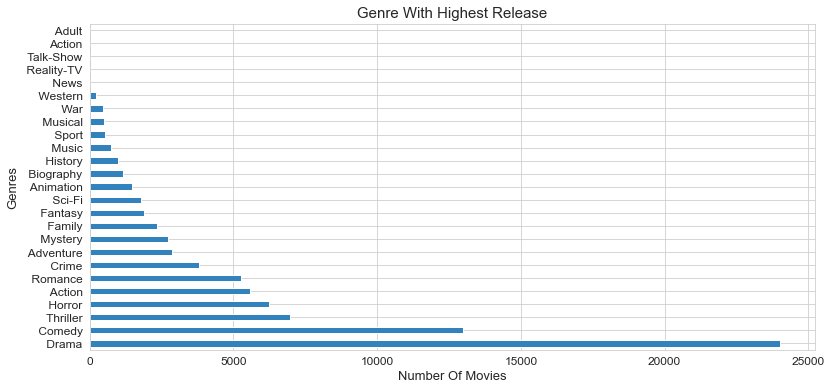

In [305]:
# movie genres comparison

def count_genre(x):
    
    #concatenate all the rows of the genres
    data_plot = df_t_m[x].str.cat(sep = ', ')
    data = pd.Series(data_plot.split(','))
    
    #conts each of the genre and return
    info = data.value_counts(ascending=False)
    return info


# call the function

total_genre_movies = count_genre('Genre')

# plot

total_genre_movies.plot(kind= 'barh',figsize = (13,6),fontsize=12,colormap='tab20c')
plt.title("Genre With Highest Release",fontsize=15)
plt.xlabel('Number Of Movies',fontsize=13)
plt.ylabel("Genres",fontsize= 13)

sns.set_style("whitegrid")

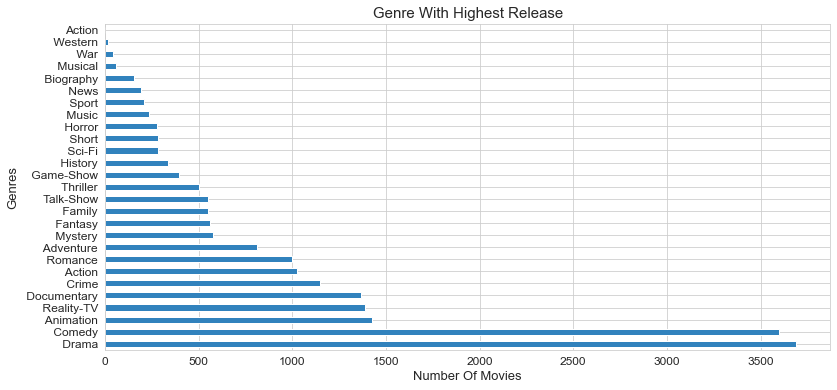

In [306]:
# tv-series genres comparison

def count_genre(x):
    
    #concatenate all the rows of the genres
    data_plot = df_t_t[x].str.cat(sep = ', ')
    data = pd.Series(data_plot.split(','))
    
    #conts each of the genre and return
    info = data.value_counts(ascending=False)
    return info


# call the function

total_genre_movies = count_genre('Genre')

#plot

total_genre_movies.plot(kind= 'barh',figsize = (13,6),fontsize=12,colormap='tab20c')
plt.title("Genre With Highest Release",fontsize=15)
plt.xlabel('Number Of Movies',fontsize=13)
plt.ylabel("Genres",fontsize= 13)

sns.set_style("whitegrid")

#### Part 3.1.2: Comparison of Individual Genres (Movies vs TV Series)

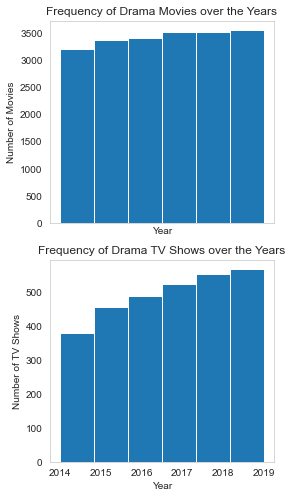

In [367]:
# drama

sns.set_style('white')

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_drama_m = df_m[df_m['Drama'] == 1]
df_drama_freq_m = df_drama_m[df_drama_m['Year']<2020]
ax[0].hist(df_drama_freq_m['Year'], bins = 6)

df_drama_t = df_t[df_t['Drama'] == 1]
df_drama_freq_t = df_drama_t[df_drama_t['Year']<2020]
ax[1].hist(df_drama_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Drama Movies over the Years")
ax[1].set_title("Frequency of Drama TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

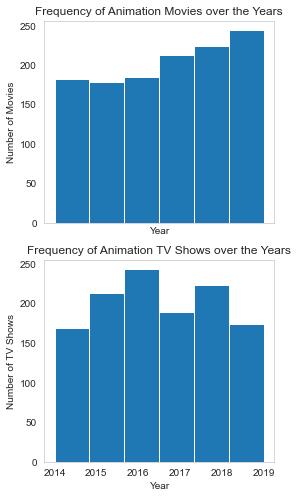

In [368]:
# animation

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_anim_m = df_m[df_m['Animation'] == 1]
df_anim_freq_m = df_anim_m[df_anim_m['Year']<2020]
ax[0].hist(df_anim_freq_m['Year'], bins = 6)

df_anim_t = df_t[df_t['Animation'] == 1]
df_anim_freq_t = df_anim_t[df_anim_t['Year']<2020]
ax[1].hist(df_anim_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Animation Movies over the Years")
ax[1].set_title("Frequency of Animation TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

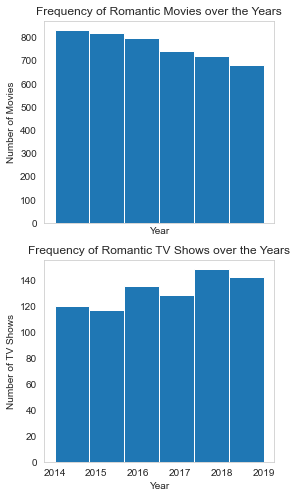

In [369]:
# romance

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_rom_m = df_m[df_m['Romance'] == 1]
df_rom_freq_m = df_rom_m[df_rom_m['Year']<2020]
ax[0].hist(df_rom_freq_m['Year'], bins = 6)

df_rom_t = df_t[df_t['Romance'] == 1]
df_rom_freq_t = df_rom_t[df_rom_t['Year']<2020]
ax[1].hist(df_rom_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Romantic Movies over the Years")
ax[1].set_title("Frequency of Romantic TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

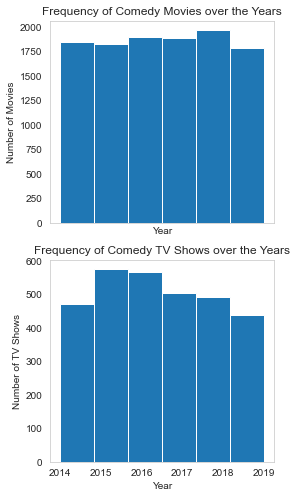

In [370]:
# comedy

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_com_m = df_m[df_m['Comedy'] == 1]
df_com_freq_m = df_com_m[df_com_m['Year']<2020]
ax[0].hist(df_com_freq_m['Year'], bins = 6)

df_com_t = df_t[df_t['Comedy'] == 1]
df_com_freq_t = df_com_t[df_com_t['Year']<2020]
ax[1].hist(df_com_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Comedy Movies over the Years")
ax[1].set_title("Frequency of Comedy TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

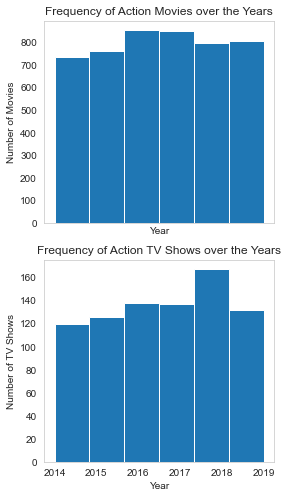

In [371]:
# action

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_actn_m = df_m[df_m['Action'] == 1]
df_actn_freq_m = df_actn_m[df_actn_m['Year']<2020]
ax[0].hist(df_actn_freq_m['Year'], bins = 6)

df_actn_t = df_t[df_t['Action'] == 1]
df_actn_freq_t = df_actn_t[df_actn_t['Year']<2020]
ax[1].hist(df_actn_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Action Movies over the Years")
ax[1].set_title("Frequency of Action TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

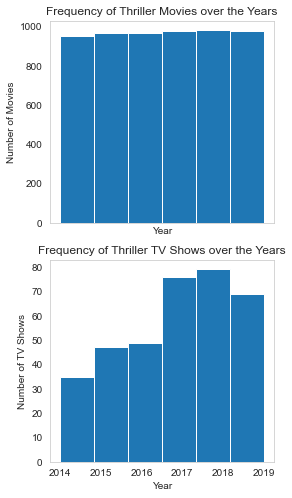

In [372]:
# thriller

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_thrl_m = df_m[df_m['Thriller'] == 1]
df_thrl_freq_m = df_thrl_m[df_thrl_m['Year']<2020]
ax[0].hist(df_thrl_freq_m['Year'], bins = 6)

df_thrl_t = df_t[df_t['Thriller'] == 1]
df_thrl_freq_t = df_thrl_t[df_thrl_t['Year']<2020]
ax[1].hist(df_thrl_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Thriller Movies over the Years")
ax[1].set_title("Frequency of Thriller TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

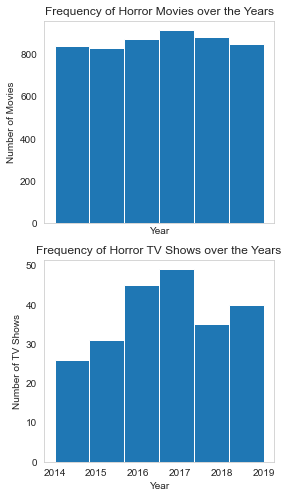

In [373]:
# horror

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_horror_m = df_m[df_m['Horror'] == 1]
df_horror_freq_m = df_horror_m[df_horror_m['Year']<2020]
ax[0].hist(df_horror_freq_m['Year'], bins = 6)

df_horror_t = df_t[df_t['Horror'] == 1]
df_horror_freq_t = df_horror_t[df_horror_t['Year']<2020]
ax[1].hist(df_horror_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Horror Movies over the Years")
ax[1].set_title("Frequency of Horror TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

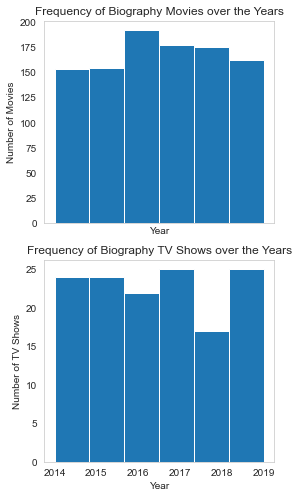

In [374]:
# biography

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_bio_m = df_m[df_m['Biography'] == 1]
df_bio_freq_m = df_bio_m[df_bio_m['Year']<2020]
ax[0].hist(df_bio_freq_m['Year'], bins = 6)

df_bio_t = df_t[df_t['Biography'] == 1]
df_bio_freq_t = df_bio_t[df_bio_t['Year']<2020]
ax[1].hist(df_bio_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Biography Movies over the Years")
ax[1].set_title("Frequency of Biography TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

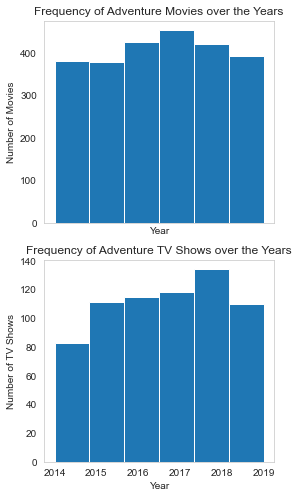

In [375]:
# adventure

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_adv_m = df_m[df_m['Adventure'] == 1]
df_adv_freq_m = df_adv_m[df_adv_m['Year']<2020]
ax[0].hist(df_adv_freq_m['Year'], bins = 6)

df_adv_t = df_t[df_t['Adventure'] == 1]
df_adv_freq_t = df_adv_t[df_adv_t['Year']<2020]
ax[1].hist(df_adv_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Adventure Movies over the Years")
ax[1].set_title("Frequency of Adventure TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

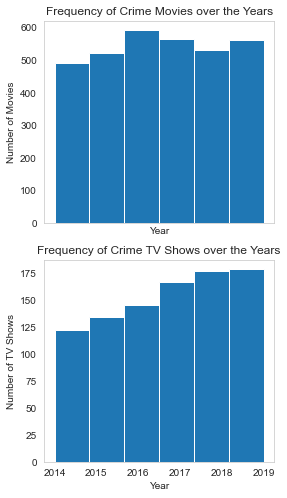

In [376]:
# crime

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_cri_m = df_m[df_m['Crime'] == 1]
df_cri_freq_m = df_cri_m[df_cri_m['Year']<2020]
ax[0].hist(df_cri_freq_m['Year'], bins = 6)

df_cri_t = df_t[df_t['Crime'] == 1]
df_cri_freq_t = df_cri_t[df_cri_t['Year']<2020]
ax[1].hist(df_cri_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Crime Movies over the Years")
ax[1].set_title("Frequency of Crime TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

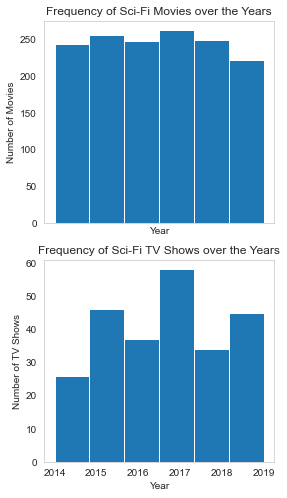

In [377]:
# sci-fi

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_scfi_m = df_m[df_m['Sci-Fi'] == 1]
df_scfi_freq_m = df_scfi_m[df_scfi_m['Year']<2020]
ax[0].hist(df_scfi_freq_m['Year'], bins = 6)

df_scfi_t = df_t[df_t['Sci-Fi'] == 1]
df_scfi_freq_t = df_scfi_t[df_scfi_t['Year']<2020]
ax[1].hist(df_scfi_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Sci-Fi Movies over the Years")
ax[1].set_title("Frequency of Sci-Fi TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

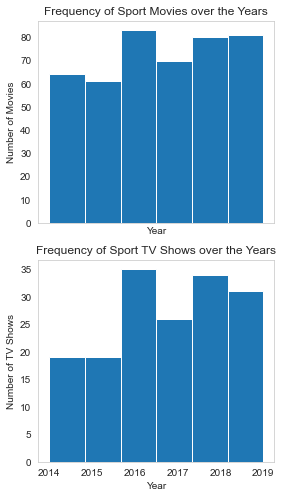

In [378]:
# sport

f,ax = plt.subplots(2,1, figsize=(4,7), sharex = True)

df_sport_m = df_m[df_m['Sport'] == 1]
df_sport_freq_m = df_sport_m[df_sport_m['Year']<2020]
ax[0].hist(df_sport_freq_m['Year'], bins = 6)

df_sport_t = df_t[df_t['Sport'] == 1]
df_sport_freq_t = df_sport_t[df_sport_t['Year']<2020]
ax[1].hist(df_sport_freq_t['Year'], bins = 6)

ax[0].set_title("Frequency of Sport Movies over the Years")
ax[1].set_title("Frequency of Sport TV Shows over the Years")

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Movies')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of TV Shows')

f.tight_layout(pad=1.0)

### Part 3.2: Comparing the IMDb of different Genre based on the Target Age Group

In [379]:
df_drama_all_m = df_drama_m[df_drama_m['All']==1]
df_drama_ad_m = df_drama_m[df_drama_m['Adults']==1]
print("Drama Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_drama_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_drama_ad_m.IMDb.mean()))

print("\n")

df_drama_all_t = df_drama_t[df_drama_t['All']==1]
df_drama_ad_t = df_drama_t[df_drama_t['Adults']==1]
print("Drama Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_drama_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_drama_ad_t.IMDb.mean()))

Drama Movies:
Average IMDb (All): 6.3
Average IMDb (Only Adults): 6.3


Drama Television Series:
Average IMDb (All): 7.2
Average IMDb (Only Adults): 7.4


In [380]:
df_anim_all_m = df_anim_m[df_anim_m['All']==1]
df_anim_ad_m = df_anim_m[df_anim_m['Adults']==1]
print("Animated Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_anim_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_anim_ad_m.IMDb.mean()))

print("\n")

df_anim_all_t = df_anim_t[df_anim_t['All']==1]
df_anim_ad_t = df_anim_t[df_anim_t['Adults']==1]
print("Animated Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_anim_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_anim_ad_t.IMDb.mean()))

Animated Movies:
Average IMDb (All): 6.6
Average IMDb (Only Adults): 5.8


Animated Television Series:
Average IMDb (All): 7.1
Average IMDb (Only Adults): 7.5


In [381]:
df_rom_all_m = df_rom_m[df_rom_m['All']==1]
df_rom_ad_m = df_rom_m[df_rom_m['Adults']==1]
print("Romantic Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_rom_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_rom_ad_m.IMDb.mean()))

print("\n")

df_rom_all_t = df_rom_t[df_rom_t['All']==1]
df_rom_ad_t = df_rom_t[df_rom_t['Adults']==1]
print("Romantic Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_rom_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_rom_ad_t.IMDb.mean()))

Romantic Movies:
Average IMDb (All): 6.1
Average IMDb (Only Adults): 5.8


Romantic Television Series:
Average IMDb (All): 7.3
Average IMDb (Only Adults): 7.5


In [382]:
df_com_all_m = df_com_m[df_com_m['All']==1]
df_com_ad_m = df_com_m[df_com_m['Adults']==1]
print("Comedy Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_com_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_com_ad_m.IMDb.mean()))

print("\n")

df_com_all_t = df_com_t[df_com_t['All']==1]
df_com_ad_t = df_com_t[df_com_t['Adults']==1]
print("Comedy Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_com_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_com_ad_t.IMDb.mean()))

Comedy Movies:
Average IMDb (All): 5.9
Average IMDb (Only Adults): 5.8


Comedy Television Series:
Average IMDb (All): 7.2
Average IMDb (Only Adults): 7.5


In [383]:
df_actn_all_m = df_actn_m[df_actn_m['All']==1]
df_actn_ad_m = df_actn_m[df_actn_m['Adults']==1]
print("Action Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_actn_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_actn_ad_m.IMDb.mean()))

print("\n")

df_actn_all_t = df_actn_t[df_actn_t['All']==1]
df_actn_ad_t = df_actn_t[df_actn_t['Adults']==1]
print("Action Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_actn_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_actn_ad_t.IMDb.mean()))

Action Movies:
Average IMDb (All): 5.8
Average IMDb (Only Adults): 6.1


Action Television Series:
Average IMDb (All): 7.3
Average IMDb (Only Adults): 7.4


In [384]:
df_thrl_all_m = df_thrl_m[df_thrl_m['All']==1]
df_thrl_ad_m = df_thrl_m[df_thrl_m['Adults']==1]
print("Thriller Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_thrl_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_thrl_ad_m.IMDb.mean()))

print("\n")

df_thrl_all_t = df_thrl_t[df_thrl_t['All']==1]
df_thrl_ad_t = df_thrl_t[df_thrl_t['Adults']==1]
print("Thriller Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_thrl_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_thrl_ad_t.IMDb.mean()))

Thriller Movies:
Average IMDb (All): 5.8
Average IMDb (Only Adults): 5.8


Thriller Television Series:
Average IMDb (All): 7.1
Average IMDb (Only Adults): 7.3


In [385]:
df_horror_all_m = df_horror_m[df_horror_m['All']==1]
df_horror_ad_m = df_horror_m[df_horror_m['Adults']==1]
print("Horror Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_horror_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_horror_ad_m.IMDb.mean()))

print("\n")

df_horror_all_t = df_horror_t[df_horror_t['All']==1]
df_horror_ad_t = df_horror_t[df_horror_t['Adults']==1]
print("Horror Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_horror_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_horror_ad_t.IMDb.mean()))

Horror Movies:
Average IMDb (All): 5.1
Average IMDb (Only Adults): 5.7


Horror Television Series:
Average IMDb (All): 6.9
Average IMDb (Only Adults): 6.5


In [386]:
df_bio_all_m = df_bio_m[df_bio_m['All']==1]
df_bio_ad_m = df_bio_m[df_bio_m['Adults']==1]
print("Biography Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_bio_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_bio_ad_m.IMDb.mean()))

print("\n")

df_bio_all_t = df_bio_t[df_bio_t['All']==1]
df_bio_ad_t = df_bio_t[df_bio_t['Adults']==1]
print("Biography Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_bio_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_bio_ad_t.IMDb.mean()))

Biography Movies:
Average IMDb (All): 6.7
Average IMDb (Only Adults): 6.7


Biography Television Series:
Average IMDb (All): 6.8
Average IMDb (Only Adults): 7.9


In [387]:
df_adv_all_m = df_adv_m[df_adv_m['All']==1]
df_adv_ad_m = df_adv_m[df_adv_m['Adults']==1]
print("Adventure Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_adv_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_adv_ad_m.IMDb.mean()))

print("\n")

df_adv_all_t = df_adv_t[df_adv_t['All']==1]
df_adv_ad_t = df_adv_t[df_adv_t['Adults']==1]
print("Adventure Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_adv_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_adv_ad_t.IMDb.mean()))

Adventure Movies:
Average IMDb (All): 6.1
Average IMDb (Only Adults): 5.9


Adventure Television Series:
Average IMDb (All): 7.1
Average IMDb (Only Adults): 7.4


In [388]:
df_cri_all_m = df_cri_m[df_cri_m['All']==1]
df_cri_ad_m = df_cri_m[df_cri_m['Adults']==1]
print("Crime Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_cri_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_cri_ad_m.IMDb.mean()))

print("\n")

df_cri_all_t = df_cri_t[df_cri_t['All']==1]
df_cri_ad_t = df_cri_t[df_cri_t['Adults']==1]
print("Crime Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_cri_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_cri_ad_t.IMDb.mean()))

Crime Movies:
Average IMDb (All): 6.0
Average IMDb (Only Adults): 6.3


Crime Television Series:
Average IMDb (All): 7.4
Average IMDb (Only Adults): 7.6


In [389]:
df_scfi_all_m = df_scfi_m[df_scfi_m['All']==1]
df_scfi_ad_m = df_scfi_m[df_scfi_m['Adults']==1]
print("Sci-Fi Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_scfi_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_scfi_ad_m.IMDb.mean()))

print("\n")

df_scfi_all_t = df_scfi_t[df_scfi_t['All']==1]
df_scfi_ad_t = df_scfi_t[df_scfi_t['Adults']==1]
print("Sci-Fi Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_scfi_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_scfi_ad_t.IMDb.mean()))

Sci-Fi Movies:
Average IMDb (All): 5.7
Average IMDb (Only Adults): 6.1


Sci-Fi Television Series:
Average IMDb (All): 6.7
Average IMDb (Only Adults): 7.1


In [390]:
df_sport_all_m = df_sport_m[df_sport_m['All']==1]
df_sport_ad_m = df_sport_m[df_sport_m['Adults']==1]
print("Sport Movies:")
print("Average IMDb (All): " + "{:.1f}".format(df_sport_all_m.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_sport_ad_m.IMDb.mean()))

print("\n")

df_sport_all_t = df_sport_t[df_sport_t['All']==1]
df_sport_ad_t = df_sport_t[df_sport_t['Adults']==1]
print("Sport Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_sport_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_sport_ad_t.IMDb.mean()))

Sport Movies:
Average IMDb (All): 6.2
Average IMDb (Only Adults): 6.4


Sport Television Series:
Average IMDb (All): 6.2
Average IMDb (Only Adults): 7.9


In [391]:
# only available for TV Series

df_rltv_t = df_t[df_t['Reality-TV']==1]
df_rltv_all_t = df_rltv_t[df_rltv_t['All']==1]
df_rltv_ad_t = df_rltv_t[df_rltv_t['Adults']==1]
print("Reality-TV Television Series:")
print("Average IMDb (All): " + "{:.1f}".format(df_rltv_all_t.IMDb.mean()))
print("Average IMDb (Only Adults): " + "{:.1f}".format(df_rltv_ad_t.IMDb.mean()))

Reality-TV Television Series:
Average IMDb (All): 6.8
Average IMDb (Only Adults): 5.8


### Part 3.3: Comparing the impact of Duration on IMDb

#### Part 3.3.1: Movie Dataset

Text(0.5, 1.0, 'IMDb of Movies based on Duration Categories over the Years')

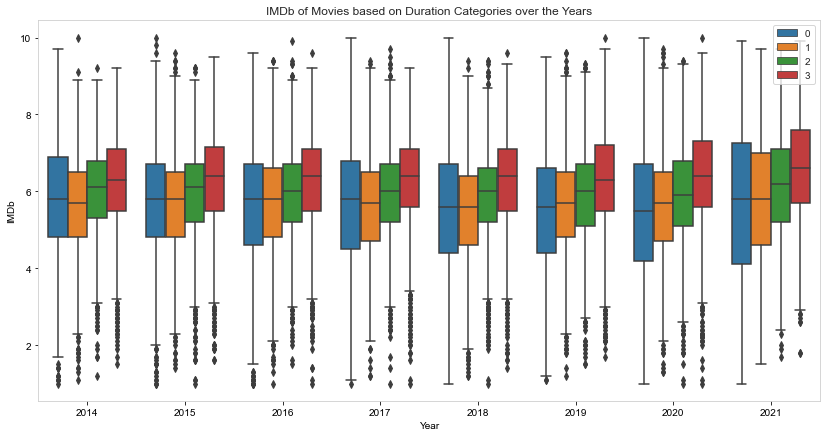

In [394]:
# using the duration split dataset of movies

sns.reset_orig()
%matplotlib inline

fig, ax = plt.subplots(figsize = (14, 7))
sns.boxplot(x = 'Year', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_m)
plt.legend(loc='upper right')
ax.set_title('IMDb of Movies based on Duration Categories over the Years')

#### Part 3.3.2: Television Series Dataset

Text(0.5, 1.0, 'IMDb of TV-Series based on Duration Categories over the Years')

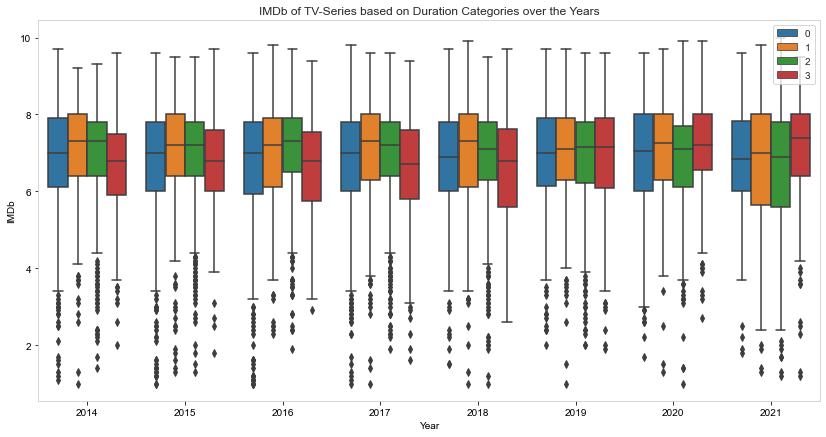

In [395]:
# using the duration split dataset of tv-series

fig, ax = plt.subplots(figsize = (14, 7))
sns.boxplot(x = 'Year', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_t)
plt.legend(loc='upper right')
ax.set_title('IMDb of TV-Series based on Duration Categories over the Years')

#### Part 3.3.3: Impact of Duration on IMDb based on different Genres

Text(0.5, 1.0, 'IMDb of Drama Shows based on Duration')

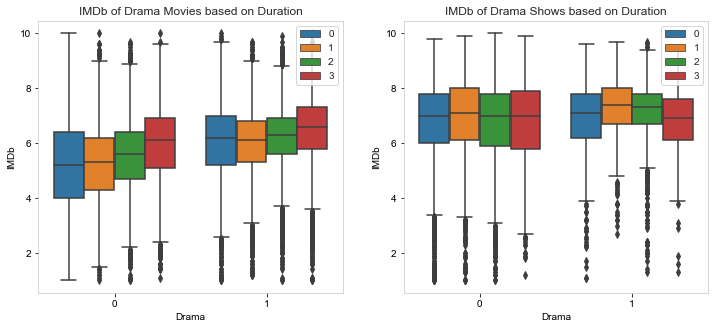

In [396]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

sns.boxplot(x = 'Drama', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_m, ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title('IMDb of Drama Movies based on Duration')

sns.boxplot(x = 'Drama', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_t, ax=ax[1])
ax[1].legend(loc='upper right')
ax[1].set_title('IMDb of Drama Shows based on Duration')

Text(0.5, 1.0, 'IMDb of Animated Shows based on Duration')

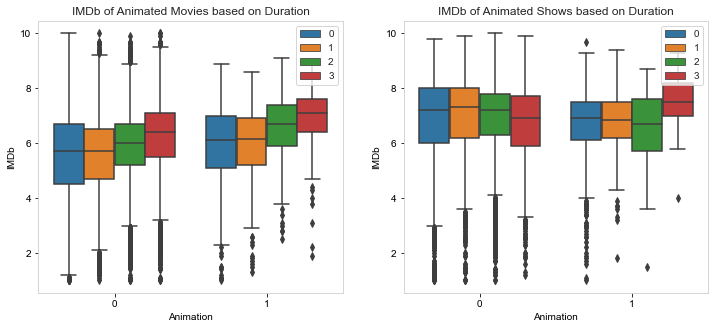

In [397]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

sns.boxplot(x = 'Animation', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_m, ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title('IMDb of Animated Movies based on Duration')

sns.boxplot(x = 'Animation', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_t, ax=ax[1])
ax[1].legend(loc='upper right')
ax[1].set_title('IMDb of Animated Shows based on Duration')

Text(0.5, 1.0, 'IMDb of Romantic Shows based on Duration')

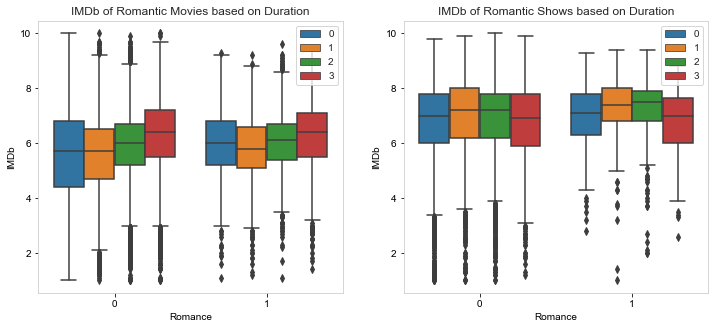

In [398]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

sns.boxplot(x = 'Romance', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_m, ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title('IMDb of Romantic Movies based on Duration')

sns.boxplot(x = 'Romance', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_t, ax=ax[1])
ax[1].legend(loc='upper right')
ax[1].set_title('IMDb of Romantic Shows based on Duration')

Text(0.5, 1.0, 'IMDb of Sport Shows based on Duration')

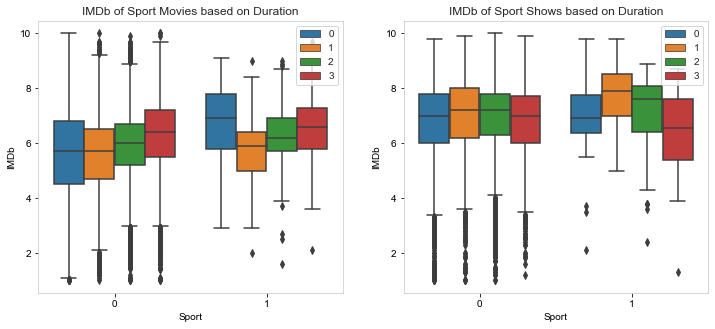

In [399]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

sns.boxplot(x = 'Sport', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_m, ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title('IMDb of Sport Movies based on Duration')

sns.boxplot(x = 'Sport', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_t, ax=ax[1])
ax[1].legend(loc='upper right')
ax[1].set_title('IMDb of Sport Shows based on Duration')

Text(0.5, 1.0, 'IMDb of Horror Shows based on Duration')

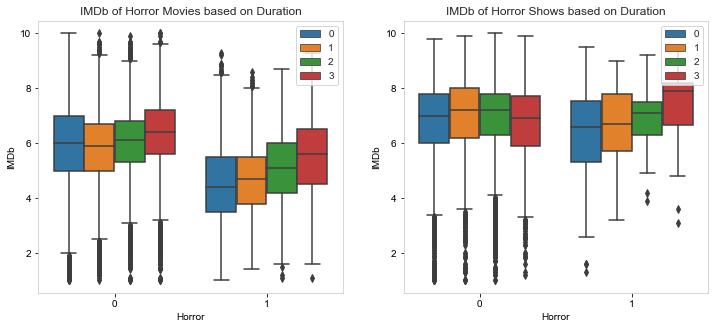

In [400]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

sns.boxplot(x = 'Horror', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_m, ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title('IMDb of Horror Movies based on Duration')

sns.boxplot(x = 'Horror', y = 'IMDb', hue = 'Duration_cat', data = df_dur_split_t, ax=ax[1])
ax[1].legend(loc='upper right')
ax[1].set_title('IMDb of Horror Shows based on Duration')

### Part 3.4: Comparing the impact of Votes on IMDb

#### Part 3.4.1: Movies Dataset

Text(0.5, 1.0, 'IMDb of Movies based on Votes over the Years')

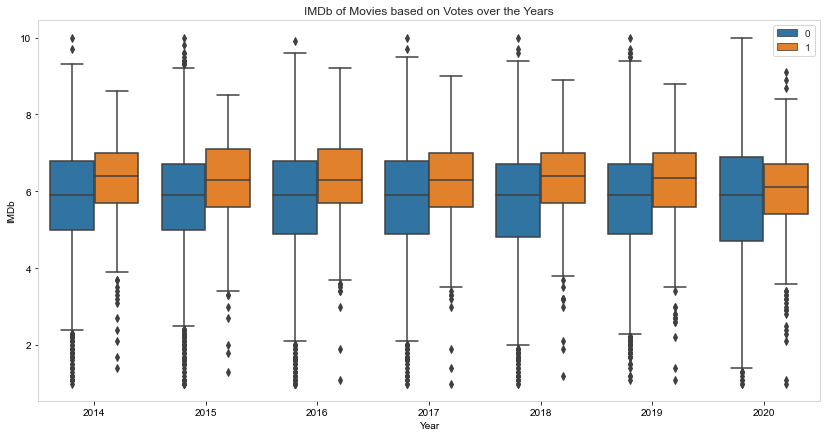

In [401]:
# using the votes split dataset of movies

fig, ax = plt.subplots(figsize = (14, 7))
sns.boxplot(x = 'Year', y = 'IMDb', hue = 'Votes_cat', data = df_votes_split_m[df_votes_split_m['Year']<2021])
plt.legend(loc='upper right')
ax.set_title('IMDb of Movies based on Votes over the Years')

#### Part 3.4.2: Television Series Dataset

Text(0.5, 1.0, 'IMDb of Movies based on Votes over the Years')

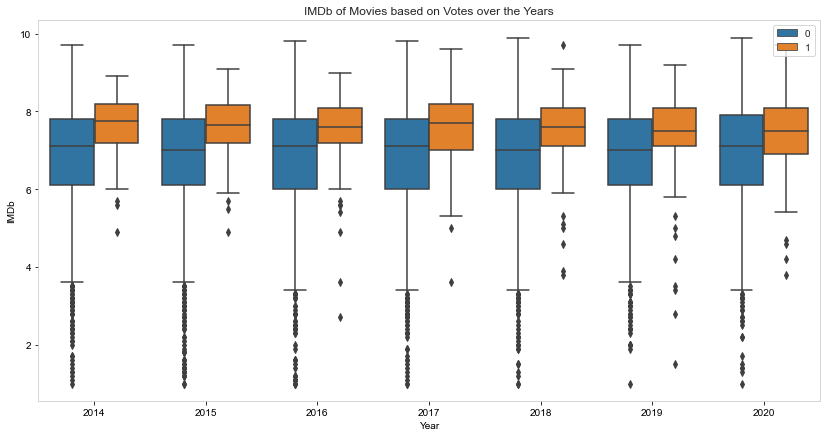

In [402]:
# using the votes split dataset of tv-series

fig, ax = plt.subplots(figsize = (14, 7))
sns.boxplot(x = 'Year', y = 'IMDb', hue = 'Votes_cat', data = df_votes_split_t[df_votes_split_t['Year']<2021])
plt.legend(loc='upper right')
ax.set_title('IMDb of Movies based on Votes over the Years')

### Part 3.5: Analysing impact of Votes on Gross Earnings for different Genres

Text(0, 0.5, 'Gross Earnings (in Million $)')

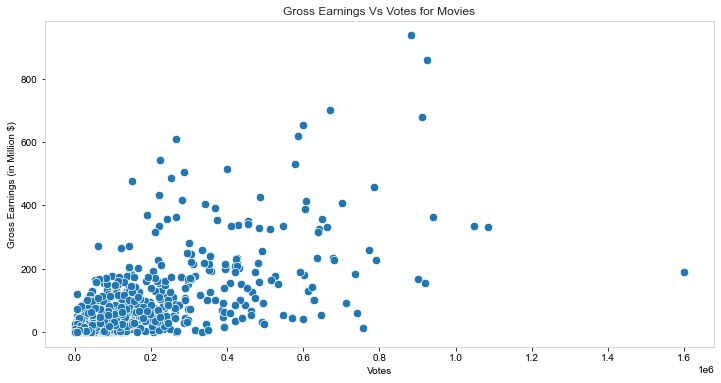

In [403]:
# this is to simply to analyse the impact of votes on gross earnings

fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x='Votes', y='Profit', data=df_profit_split_m, palette="deep", s=70)
ax.set_title("Gross Earnings Vs Votes for Movies")
ax.set_xlabel('Votes')
ax.set_ylabel('Gross Earnings (in Million $)')

Text(0, 0.5, 'Gross Earnings (in Million $)')

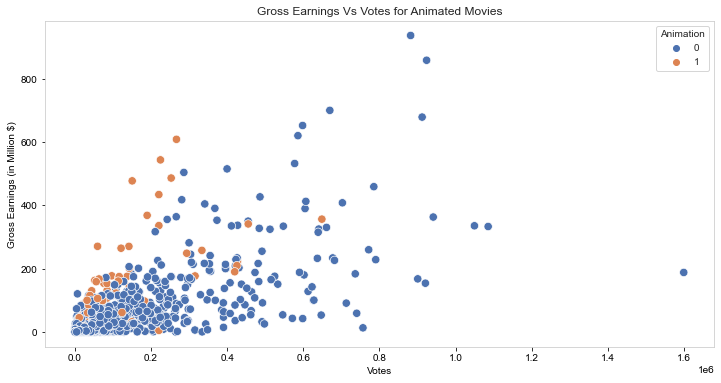

In [404]:
# this is to simply to analyse the impact of votes on gross earnings for animated movies

fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x='Votes', y='Profit', hue='Animation', data=df_profit_split_m, palette="deep", s=70)
ax.set_title("Gross Earnings Vs Votes for Animated Movies")
ax.set_xlabel('Votes')
ax.set_ylabel('Gross Earnings (in Million $)')

Text(0, 0.5, 'Gross Earnings (in Million $)')

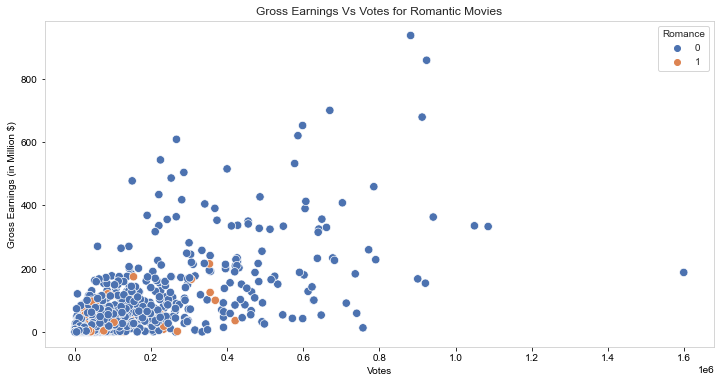

In [405]:
# this is to simply to analyse the impact of votes on gross earnings for romantic movies

fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x='Votes', y='Profit', hue='Romance', data=df_profit_split_m, palette="deep", s=70)
ax.set_title("Gross Earnings Vs Votes for Romantic Movies")
ax.set_xlabel('Votes')
ax.set_ylabel('Gross Earnings (in Million $)')

Text(0, 0.5, 'Gross Earnings (in Million $)')

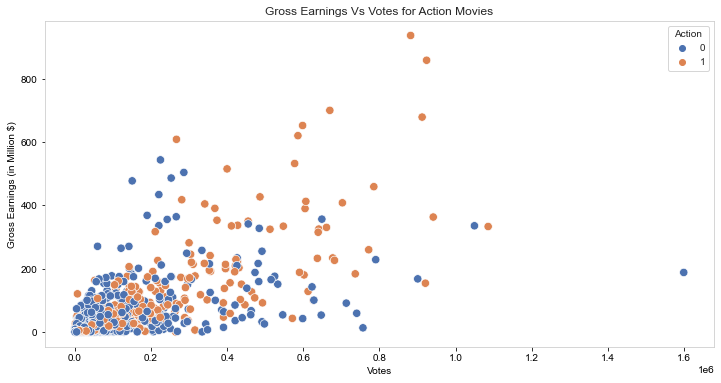

In [406]:
# this is to simply to analyse the impact of votes on gross earnings for action movies

fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x='Votes', y='Profit', hue='Action', data=df_profit_split_m, palette="deep", s=70)
ax.set_title("Gross Earnings Vs Votes for Action Movies")
ax.set_xlabel('Votes')
ax.set_ylabel('Gross Earnings (in Million $)')

### Part 3.6: Analysing the relationship between IMDb and Gross Earnings

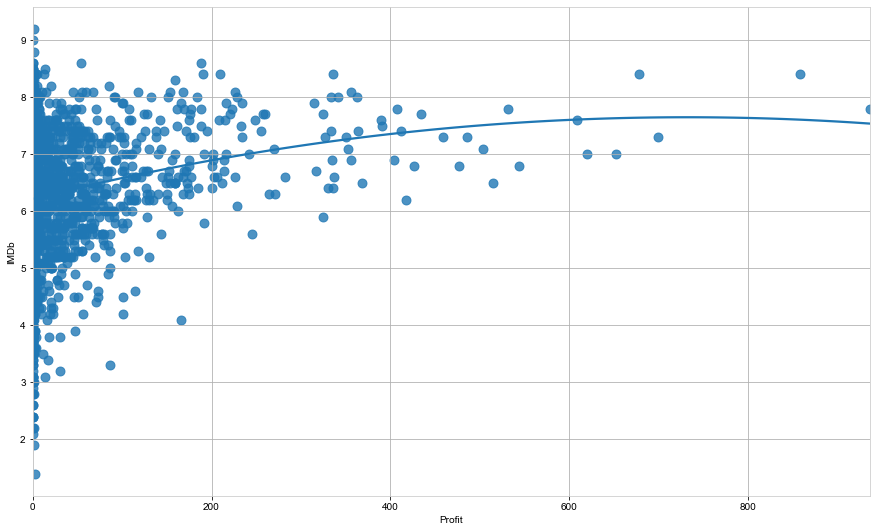

In [366]:
fig, ax = plt.subplots(figsize =(15,9))
plt.rcParams.update({'font.size':14})
plt.grid(b=None)
df_profit = sns.regplot(x="Profit", y="IMDb", data = df_profits_m, order=2, ci=None, scatter_kws={"s":80})

## Part 4: Supersived Machine Learning Model to predict Gross Earnings (Movies)

<AxesSubplot:>

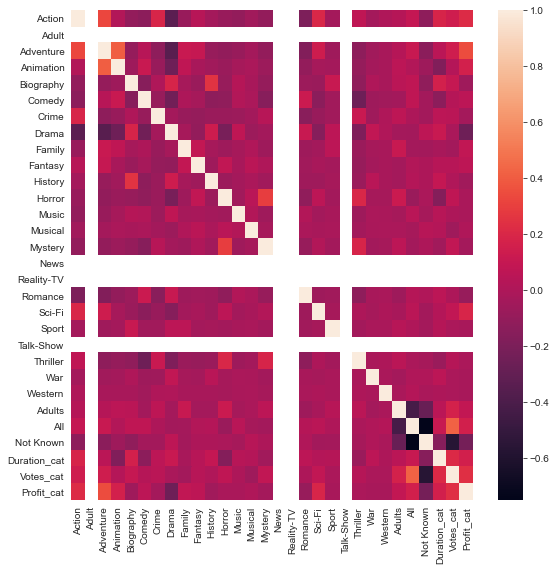

In [283]:
# correlation table to examine the relation between the different variables

df_profit_ml = df_profit_split_m.drop(['Ind', 'Year', 'IMDb', 'Profit', 'Votes', 'Duration'], axis=1)

fig, ax = plt.subplots(figsize = (9, 9))

cor_table = df_profit_ml.corr()
sns.heatmap(cor_table)

In [284]:
# implementing Support Vector Machine model for predicting gross earnings for movies

df_ml=df_profit_ml.copy()

# defining dependent and independent variables

X = df_ml.iloc[:,:-1]
y = df_ml['Profit_cat']

X = X.values
y = y.values.ravel()

# spliting the data in train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

# initializing svm model

svm = SVC(kernel='rbf')

# training and testing the model

svm.fit(X_train, y_train)
yfit = svm.predict(X_test)

# printing the accuracy

print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

0.9181478016838166
0.9121495327102803


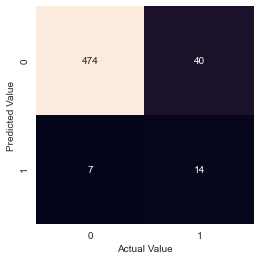

In [285]:
# creating confusion matrix

mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value');

In [286]:
# creating report for the svm model performance

print(classification_report(y_test,yfit,digits=5))

              precision    recall  f1-score   support

           0    0.92218   0.98545   0.95276       481
           1    0.66667   0.25926   0.37333        54

    accuracy                        0.91215       535
   macro avg    0.79442   0.62235   0.66305       535
weighted avg    0.89639   0.91215   0.89428       535



# Thank You